# Анализ качества ликвидности
Сравнение режимов MM / AMM (Uniswap) / HFMM без шоков, по результатам `summary.csv`.

In [ ]:
import sys, os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

cwd = Path(os.getcwd()).resolve()
repo_root = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "AgentBasedModel").exists():
        repo_root = parent
        break
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
repo_root

PosixPath('/Users/mihailledenev/PycharmProjects/AI_360_project')

In [2]:
# локальный импорт тестов на средние/дисперсии
math_path = repo_root / "AgentBasedModel" / "utils" / "math.py"
spec = importlib.util.spec_from_file_location("math_local", math_path)
math_local = importlib.util.module_from_spec(spec)
spec.loader.exec_module(math_local)
paired_ttest = math_local.paired_ttest
variance_test = math_local.variance_test
paired_ttest, variance_test

(<function math_local.paired_ttest(sample_a, sample_b, alpha: float = 0.05) -> dict>,
 <function math_local.variance_test(sample_a, sample_b, center='median') -> dict>)

## Загрузка данных
Используем `results/summary.csv`, фильтруем на базовый сценарий (без шоков).

In [3]:
summary_path = repo_root / "results" / "summary.csv"
df = pd.read_csv(summary_path)
df.head()

,scenario_id,scenario_run_id,scenario_type,agent_preset,mode,shock_value,shock_value_kind,repeat_idx,seed,panic_detected,...,n_fundamentalist,n_chartist,n_universalist,n_marketmaker,n_automarketmaker,n_hfmm,t_spread_end,spread_ref,spread_post,spread_duration
0,price_baseline_mm_00,price_baseline_mm_00_run1,base,baseline,mm,0,percent,1,124,False,...,10,10,10,1,0,0,248.0,0.633333,0.8600,48.0
1,price_baseline_mm_00,price_baseline_mm_00_run2,base,baseline,mm,0,percent,2,125,False,...,10,10,10,1,0,0,241.0,0.695000,0.6000,41.0
2,price_baseline_mm_00,price_baseline_mm_00_run3,base,baseline,mm,0,percent,3,126,False,...,10,10,10,1,0,0,241.0,0.443333,0.3725,41.0
3,price_baseline_mm_00,price_baseline_mm_00_run4,base,baseline,mm,0,percent,4,127,False,...,10,10,10,1,0,0,249.0,0.471667,0.6525,49.0
4,price_baseline_mm_00,price_baseline_mm_00_run5,base,baseline,mm,0,percent,5,128,False,...,10,10,10,1,0,0,241.0,0.365000,0.2275,41.0


In [ ]:
df_base = df[(df["scenario_type"].isin(["base", "price"])) & (df["shock_value"] == 0)]
df_base = df_base.copy()
df_base["mode"].value_counts()

mode
mm      1000
amm     1000
hfmm    1000
Name: count, dtype: int64

## Сводка по метрикам
Ключевые метрики качества ликвидности:
- `spread_mean`, `spread_std`
- `rel_spread_mean`, `rel_spread_std`
- `spread_per_vol_mean`
- `depth_band_mean`
- `n_orders_bid_mean`, `n_orders_ask_mean`
- `top_qty_mean`

In [5]:
metrics = [
    "spread_mean", "spread_std",
    "rel_spread_mean", "rel_spread_std",
    "spread_per_vol_mean",
    "depth_band_mean",
    "top_qty_mean",
    "n_orders_bid_mean", "n_orders_ask_mean",
]

summary_by_mode = df_base.groupby("mode")[metrics].agg(['mean','std'])
summary_by_mode

spread_mean           spread_std           rel_spread_mean            \
            mean       std       mean       std            mean       std   
mode                                                                        
amm     1.317498  0.124477   1.179874  0.135069        0.013165  0.001323   
hfmm    1.128321  0.100102   1.051998  0.122506        0.011269  0.001056   
mm      0.517227  0.099936   0.623671  0.131238        0.005135  0.000858   

     rel_spread_std           spread_per_vol_mean           depth_band_mean  \
               mean       std                mean       std            mean   
mode                                                                          
amm        0.011785  0.001317            0.342839  0.034858       19.555902   
hfmm       0.010500  0.001215            0.289142  0.026516       23.406840   
mm         0.006185  0.001160            0.079363  0.023173      201.724350   

                top_qty_mean            n_orders_bid_mean             \
            std         mean        std              mean        std   
mode                                                                   
amm    3.538820     4.667757   0.101626        498.128977  31.023783   
hfmm   3.650058     4.762148   0.098761        501.983493  32.996972   
mm    15.580563    72.279810  12.694772        516.227130  34.477305   

     n_orders_ask_mean             
                  mean        std  
mode                               
amm         494.401513  37.754224  
hfmm        497.393968  39.625667  
mm          507.412160  42.081889

## Визуализация распределений (по прогону)
Boxplot по основным метрикам.

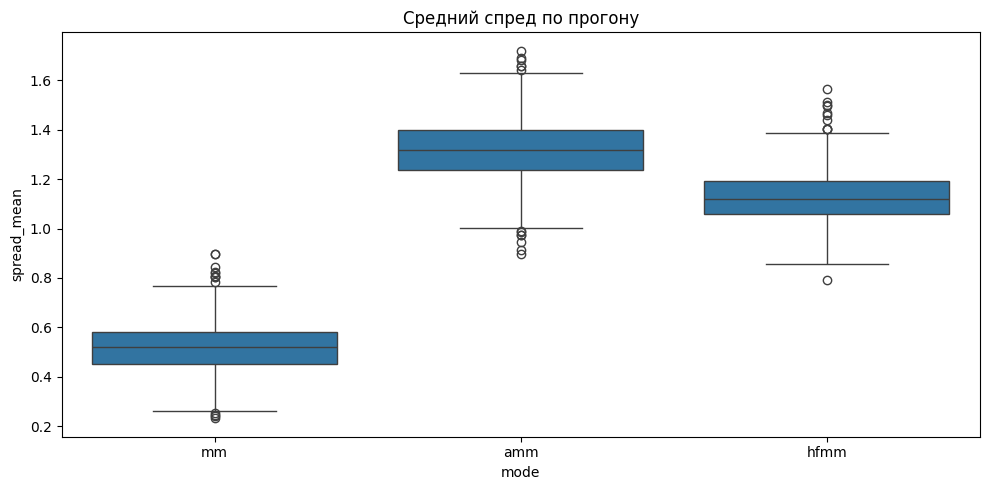

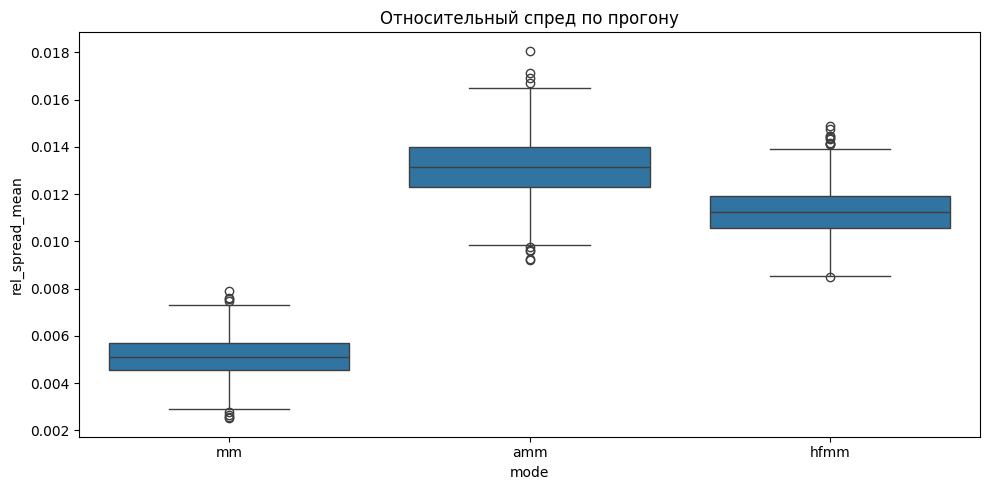

In [6]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_base, x="mode", y="spread_mean")
plt.title("Средний спред по прогону")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_base, x="mode", y="rel_spread_mean")
plt.title("Относительный спред по прогону")
plt.tight_layout()
plt.show()

## Парные сравнения AMM vs MM, HFMM vs MM, HFMM vs AMM
Используем повторные запуски с одинаковым `repeat_idx` для парного теста.

In [7]:
def pairwise(df_base, m1, m2, metric):
    a = df_base[df_base["mode"] == m1][["repeat_idx", metric]].rename(columns={metric: f"{metric}_{m1}"})
    b = df_base[df_base["mode"] == m2][["repeat_idx", metric]].rename(columns={metric: f"{metric}_{m2}"})
    merged = pd.merge(a, b, on="repeat_idx")
    res_t = paired_ttest(merged[f"{metric}_{m1}"], merged[f"{metric}_{m2}"])
    res_v = variance_test(merged[f"{metric}_{m1}"], merged[f"{metric}_{m2}"])
    diff_mean = (merged[f"{metric}_{m1}"] - merged[f"{metric}_{m2}"]).mean()
    res_t["mean_diff"] = diff_mean
    res_t["var_p_value"] = res_v["p_value"]
    return res_t

pairs = [("amm","mm"), ("hfmm","mm"), ("hfmm","amm")]
metrics_test = ["spread_mean","rel_spread_mean","spread_std","spread_per_vol_mean","depth_band_mean"]
rows = []
for m1,m2 in pairs:
    for metric in metrics_test:
        res = pairwise(df_base, m1, m2, metric)
        res["pair"] = f"{m1} vs {m2}"
        res["metric"] = metric
        rows.append(res)
pd.DataFrame(rows)[["pair","metric","n","mean_diff","t_stat","p_value","var_p_value"]]

,pair,metric,n,mean_diff,t_stat,p_value,var_p_value
0,amm vs mm,spread_mean,1000,0.800271,157.493987,0.000000e+00,2.231492e-10
1,amm vs mm,rel_spread_mean,1000,0.008030,160.154526,0.000000e+00,3.951357e-30
2,amm vs mm,spread_std,1000,0.556203,94.448562,0.000000e+00,7.826485e-01
3,amm vs mm,spread_per_vol_mean,1000,0.263476,196.765032,0.000000e+00,1.180197e-28
4,amm vs mm,depth_band_mean,1000,-182.168448,-358.089222,0.000000e+00,2.341843e-166
5,hfmm vs mm,spread_mean,1000,0.611095,133.024963,0.000000e+00,6.919594e-01
6,hfmm vs mm,rel_spread_mean,1000,0.006135,140.511813,0.000000e+00,1.502565e-09
7,hfmm vs mm,spread_std,1000,0.428327,74.145743,0.000000e+00,1.783272e-02
8,hfmm vs mm,spread_per_vol_mean,1000,0.209779,182.218273,0.000000e+00,1.098236e-04
9,hfmm vs mm,depth_band_mean,1000,-178.317510,-355.676539,0.000000e+00,1.313676e-164


## Гистограммы разностей

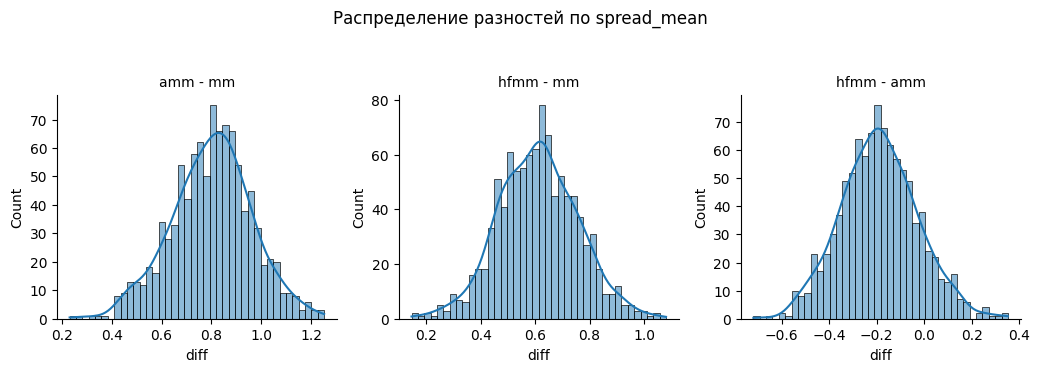

In [8]:
metric = "spread_mean"
diffs = []
for m1,m2 in pairs:
    a = df_base[df_base["mode"] == m1][["repeat_idx", metric]].rename(columns={metric: f"{metric}_{m1}"})
    b = df_base[df_base["mode"] == m2][["repeat_idx", metric]].rename(columns={metric: f"{metric}_{m2}"})
    merged = pd.merge(a, b, on="repeat_idx")
    merged["diff"] = merged[f"{metric}_{m1}"] - merged[f"{metric}_{m2}"]
    merged["pair"] = f"{m1} - {m2}"
    diffs.append(merged[["diff","pair"]])
diff_df = pd.concat(diffs, ignore_index=True)

g = sns.FacetGrid(diff_df, col="pair", sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.histplot, x="diff", kde=True, bins=40)
g.set_titles(col_template="{col_name}")
plt.suptitle(f"Распределение разностей по {metric}", y=1.05)
plt.tight_layout()
plt.show()

## Итоговое резюме
- Сводка по метрикам (mean/std) по режимам — см. summary_by_mode
- Парные тесты по ключевым метрикам — см. таблицу выше (p_value: различия средних, var_p_value: различия дисперсий)
- Отрицательная разность означает преимущество первого режима в паре (меньший спред/спред_per_vol и т.п.).